In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random
import os

# Load and prepare the data
def load_traffic_data(data_path):
    df = pd.read_csv(data_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

# Define the VSL environment
class VSLEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.speed_limits = [60, 80, 100, 120, 140]  # Available speed limits in km/h
        
        # Define state space features
        self.state_features = ['vehicle_count', 'average_speed_kmh', 'vehicle_density_vpkm']
        
        # Normalize the features for better learning
        self.feature_means = data[self.state_features].mean()
        self.feature_stds = data[self.state_features].std()
        
    def reset(self):
        self.current_step = 0
        return self._get_state()
    
    def _get_state(self):
        if self.current_step >= len(self.data):
            return None
        
        current_data = self.data.iloc[self.current_step][self.state_features]
        # Normalize the state
        normalized_state = (current_data - self.feature_means) / self.feature_stds
        return normalized_state.values.astype(np.float32)
    
    def step(self, action):
        if self.current_step >= len(self.data) - 1:
            return None, 0, True, {}
        
        # Get current traffic conditions
        current_data = self.data.iloc[self.current_step]
        
        # Apply the selected speed limit
        selected_speed_limit = self.speed_limits[action]
        
        # Advance to the next step
        self.current_step += 1
        next_data = self.data.iloc[self.current_step]
        
        # Calculate reward based on traffic efficiency and safety
        reward = self._calculate_reward(current_data, next_data, selected_speed_limit)
        
        # Get new state
        new_state = self._get_state()
        
        # Check if episode is done
        done = self.current_step >= len(self.data) - 1
        
        return new_state, reward, done, {'speed_limit': selected_speed_limit}
    
    def _calculate_reward(self, current_data, next_data, speed_limit):
        # Traffic efficiency component: Reward higher flow rates
        flow_reward = next_data['flow_rate_vph'] / 1000  # Normalize
        
        # Safety component: Penalize if speed is much higher than the limit
        speed_compliance = max(0, 1 - max(0, next_data['average_speed_kmh'] - speed_limit) / 50)
        
        # Stability component: Reward lower variations in speed
        speed_stability = 1 / (1 + abs(next_data['average_speed_kmh'] - current_data['average_speed_kmh']))
        
        # Occupancy component: Reward balanced lane utilization
        occupancy_vars = np.var([
            next_data['occupancy_lane_1'], 
            next_data['occupancy_lane_2'], 
            next_data['occupancy_lane_3']
        ])
        occupancy_balance = 1 / (1 + occupancy_vars/1000)
        
        # Combined reward
        reward = (0.4 * flow_reward + 
                  0.3 * speed_compliance + 
                  0.2 * speed_stability + 
                  0.1 * occupancy_balance)
        
        return float(reward)

# Implement Deep Q-Network agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    
    def _build_model(self):
        model = keras.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(np.array([state], dtype=np.float32), verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        
        states = np.array([i[0] for i in minibatch], dtype=np.float32)
        actions = np.array([i[1] for i in minibatch], dtype=np.int32)
        rewards = np.array([i[2] for i in minibatch], dtype=np.float32)
        next_states = np.array([i[3] for i in minibatch], dtype=np.float32)
        dones = np.array([i[4] for i in minibatch], dtype=np.bool_)
        
        mask = ~np.array([ns is None for ns in next_states])
        if not np.any(mask):
            return
            
        targets = np.zeros((len(minibatch), self.action_size), dtype=np.float32)
        target_f = self.model.predict(states, verbose=0)
        
        if np.any(~dones):
            valid_next_states = next_states[~dones]
            if len(valid_next_states) > 0:
                next_qs_array = self.model.predict(valid_next_states, verbose=0)
                next_qs = np.zeros(len(dones))
                next_qs[~dones] = np.max(next_qs_array, axis=1)
        
        for i, (_, action, reward, _, done) in enumerate(minibatch):
            target = reward
            if not done:
                target += self.gamma * next_qs[i]
            target_f[i][action] = target
            
        self.model.fit(states, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)

# Main training function
def train_vsl_agent(data, episodes=100, batch_size=32):
    env = VSLEnvironment(data)
    state_size = len(env.state_features)
    action_size = len(env.speed_limits)
    agent = DQNAgent(state_size, action_size)
    
    results = {
        'episode': [],
        'average_reward': [],
        'speed_limits': []
    }
    
    best_reward = float('-inf')  # Track best average reward
    best_model_path = "models/vsl_best_model.weights.h5"  # Path for best model
    
    # Ensure models directory exists
    os.makedirs("models", exist_ok=True)
    
    for episode in range(episodes):
        total_reward = 0
        state = env.reset()
        speed_limits_applied = []
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            if next_state is None:
                break
                
            speed_limits_applied.append(info['speed_limit'])
            total_reward += reward
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
        
        if len(agent.memory) >= batch_size:
            agent.replay(batch_size)
        
        # Calculate average reward for the episode
        avg_reward = total_reward / len(data)
        
        # Save model if this episode's reward is the best
        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.save(best_model_path)
            print(f"New best reward: {best_reward:.4f}, model saved to {best_model_path}")
        
        results['episode'].append(episode)
        results['average_reward'].append(avg_reward)
        results['speed_limits'].append(speed_limits_applied)
        
        print(f"Episode: {episode+1}/{episodes}, Avg Reward: {avg_reward:.4f}")
    
    # Save the final model as well
    agent.save("models/vsl_final_model.weights.h5")
    return results, agent



d:\Users\pc\OneDrive\Documents\4cp\S2\Project_2cs\code\myexample\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


New best reward: 0.3976, model saved to models/vsl_best_model.weights.h5
Episode: 1/50, Avg Reward: 0.3976
New best reward: 0.4124, model saved to models/vsl_best_model.weights.h5
Episode: 2/50, Avg Reward: 0.4124
Episode: 3/50, Avg Reward: 0.4107
New best reward: 0.4234, model saved to models/vsl_best_model.weights.h5
Episode: 4/50, Avg Reward: 0.4234
Episode: 5/50, Avg Reward: 0.4018
Episode: 6/50, Avg Reward: 0.3672
Episode: 7/50, Avg Reward: 0.3853
Episode: 8/50, Avg Reward: 0.3892
Episode: 9/50, Avg Reward: 0.4082
New best reward: 0.4350, model saved to models/vsl_best_model.weights.h5
Episode: 10/50, Avg Reward: 0.4350
Episode: 11/50, Avg Reward: 0.3796
Episode: 12/50, Avg Reward: 0.3838
Episode: 13/50, Avg Reward: 0.3682
Episode: 14/50, Avg Reward: 0.3540
Episode: 15/50, Avg Reward: 0.3265
Episode: 16/50, Avg Reward: 0.4242
Episode: 17/50, Avg Reward: 0.4203
Episode: 18/50, Avg Reward: 0.3807
Episode: 19/50, Avg Reward: 0.4314
Episode: 20/50, Avg Reward: 0.3798
Episode: 21/50, A

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random
import os


# Load and prepare the data
def load_traffic_data(data_path):
    df = pd.read_csv(data_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


# Visualize results


# Run the complete pipeline
def run_vsl_pipeline():
    data = load_traffic_data("traffic_data_2.csv")
    results, agent = train_vsl_agent(data, episodes=50)
    timestamps, recommended_speeds, actual_speeds, rewards = evaluate_vsl_agent(data, agent)
    visualize_results(timestamps, recommended_speeds, actual_speeds, rewards)
    return results

if __name__ == "__main__":
    results = run_vsl_pipeline()
    print("VSL implementation completed. Results saved to 'vsl_results.png'")

# Loading Pre-trained Models and Evaluation

This section demonstrates how to load pre-trained VSL models and evaluate them without retraining. This is useful when you have already trained a model and want to quickly visualize its performance on different datasets.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random
import os


# Load and prepare the data
def load_traffic_data(data_path):
    df = pd.read_csv(data_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [3]:
class VSLEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.speed_limits = [60, 80, 100, 120, 140]  # Available speed limits in km/h
        
        # Define state space features
        self.state_features = ['vehicle_count', 'average_speed_kmh', 'vehicle_density_vpkm']
        
        # Normalize the features for better learning
        self.feature_means = data[self.state_features].mean()
        self.feature_stds = data[self.state_features].std()
        
    def reset(self):
        self.current_step = 0
        return self._get_state()
    
    def _get_state(self):
        if self.current_step >= len(self.data):
            return None
        
        current_data = self.data.iloc[self.current_step][self.state_features]
        # Normalize the state
        normalized_state = (current_data - self.feature_means) / self.feature_stds
        return normalized_state.values.astype(np.float32)
    
    def step(self, action):
        if self.current_step >= len(self.data) - 1:
            return None, 0, True, {}
        
        # Get current traffic conditions
        current_data = self.data.iloc[self.current_step]
        
        # Apply the selected speed limit
        selected_speed_limit = self.speed_limits[action]
        
        # Advance to the next step
        self.current_step += 1
        next_data = self.data.iloc[self.current_step]
        
        # Calculate reward based on traffic efficiency and safety
        reward = self._calculate_reward(current_data, next_data, selected_speed_limit)
        
        # Get new state
        new_state = self._get_state()
        
        # Check if episode is done
        done = self.current_step >= len(self.data) - 1
        
        return new_state, reward, done, {'speed_limit': selected_speed_limit}
    
    def _calculate_reward(self, current_data, next_data, speed_limit):
        # Traffic efficiency component: Reward higher flow rates
        flow_reward = next_data['flow_rate_vph'] / 1000  # Normalize
        
        # Safety component: Penalize if speed is much higher than the limit
        speed_compliance = max(0, 1 - max(0, next_data['average_speed_kmh'] - speed_limit) / 50)
        
        # Stability component: Reward lower variations in speed
        speed_stability = 1 / (1 + abs(next_data['average_speed_kmh'] - current_data['average_speed_kmh']))
        
        # Occupancy component: Reward balanced lane utilization
        occupancy_vars = np.var([
            next_data['occupancy_lane_1'], 
            next_data['occupancy_lane_2'], 
            next_data['occupancy_lane_3']
        ])
        occupancy_balance = 1 / (1 + occupancy_vars/1000)
        
        # Combined reward
        reward = (0.4 * flow_reward + 
                  0.3 * speed_compliance + 
                  0.2 * speed_stability + 
                  0.1 * occupancy_balance)
        
        return float(reward)

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    
    def _build_model(self):
        model = keras.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(np.array([state], dtype=np.float32), verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        
        states = np.array([i[0] for i in minibatch], dtype=np.float32)
        actions = np.array([i[1] for i in minibatch], dtype=np.int32)
        rewards = np.array([i[2] for i in minibatch], dtype=np.float32)
        next_states = np.array([i[3] for i in minibatch], dtype=np.float32)
        dones = np.array([i[4] for i in minibatch], dtype=np.bool_)
        
        mask = ~np.array([ns is None for ns in next_states])
        if not np.any(mask):
            return
            
        targets = np.zeros((len(minibatch), self.action_size), dtype=np.float32)
        target_f = self.model.predict(states, verbose=0)
        
        if np.any(~dones):
            valid_next_states = next_states[~dones]
            if len(valid_next_states) > 0:
                next_qs_array = self.model.predict(valid_next_states, verbose=0)
                next_qs = np.zeros(len(dones))
                next_qs[~dones] = np.max(next_qs_array, axis=1)
        
        for i, (_, action, reward, _, done) in enumerate(minibatch):
            target = reward
            if not done:
                target += self.gamma * next_qs[i]
            target_f[i][action] = target
            
        self.model.fit(states, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)

In [5]:

# Evaluate the trained agent
def evaluate_vsl_agent(data, agent):
    env = VSLEnvironment(data)
    state = env.reset()
    recommended_speeds = []
    actual_speeds = []
    rewards = []
    timestamps = []
    done = False
    
    while not done:
        action = agent.act(state)
        speed_limit = env.speed_limits[action]
        recommended_speeds.append(speed_limit)
        
        current_data = data.iloc[env.current_step]
        actual_speeds.append(current_data['average_speed_kmh'])
        timestamps.append(current_data['timestamp'])
        
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        if next_state is None:
            break
        state = next_state
    
    return timestamps, recommended_speeds, actual_speeds, rewards

In [6]:
def visualize_results(timestamps, recommended_speeds, actual_speeds, rewards, save_to_file=True, data=None):
    # Check if data is provided for enhanced visualization
    if data is not None:
        # Create a figure with 2x2 subplots for enhanced visualization
        plt.figure(figsize=(16, 12))
        
        # Plot 1: Recommended speed limits and actual speeds over time
        plt.subplot(2, 2, 1)
        plt.plot(timestamps, recommended_speeds, 'b-', label='Recommended Speed Limit')
        plt.plot(timestamps, actual_speeds, 'r-', label='Actual Average Speed')
        plt.ylabel('Speed (km/h)')
        plt.title('VSL Recommendations vs. Actual Speeds')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Rewards over time
        plt.subplot(2, 2, 2)
        plt.plot(timestamps, rewards, 'g-', label='Reward')
        plt.ylabel('Reward')
        plt.xlabel('Time')
        plt.title('Agent Rewards Over Time')
        plt.legend()
        plt.grid(True)
        
        # Plot 3: Recommended speeds vs vehicle count
        plt.subplot(2, 2, 3)
        
        # Create a dataframe for the analysis
        df_analysis = pd.DataFrame({
            'timestamp': timestamps,
            'recommended_speed': recommended_speeds
        })
        
        # Merge with the traffic data to get vehicle counts
        merged_df = pd.merge(df_analysis, data, on='timestamp')
        
        # Create scatter plot of recommended speeds vs vehicle count
        plt.scatter(merged_df['vehicle_count'], merged_df['recommended_speed'], 
                   c='blue', alpha=0.6, label='Recommended Speed')
        
        # Add trendline
        if len(merged_df) > 1:
            z = np.polyfit(merged_df['vehicle_count'], merged_df['recommended_speed'], 1)
            p = np.poly1d(z)
            x_sorted = sorted(merged_df['vehicle_count'])
            plt.plot(x_sorted, p(x_sorted), 'b--', 
                     label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')
        
        plt.xlabel('Vehicle Count')
        plt.ylabel('Recommended Speed (km/h)')
        plt.title('Recommended Speed vs. Vehicle Count')
        plt.legend()
        plt.grid(True)
        
        # Plot 4: Distribution of speed recommendations
        plt.subplot(2, 2, 4)
        plt.hist(recommended_speeds, bins=len(set(recommended_speeds)), 
                alpha=0.7, color='blue', label='Recommended Speeds')
        plt.title('Distribution of Recommended Speeds')
        plt.xlabel('Speed (km/h)')
        plt.ylabel('Frequency')
        plt.grid(True)
        
    else:
        # Original 2-plot layout if no traffic data is provided
        plt.figure(figsize=(14, 8))
        
        # Plot recommended speed limits and actual speeds
        plt.subplot(2, 1, 1)
        plt.plot(timestamps, recommended_speeds, 'b-', label='Recommended Speed Limit')
        plt.plot(timestamps, actual_speeds, 'r-', label='Actual Average Speed')
        plt.ylabel('Speed (km/h)')
        plt.title('VSL Recommendations vs. Actual Speeds')
        plt.legend()
        plt.grid(True)
        
        # Plot rewards
        plt.subplot(2, 1, 2)
        plt.plot(timestamps, rewards, 'g-', label='Reward')
        plt.ylabel('Reward')
        plt.xlabel('Time')
        plt.title('Agent Rewards Over Time')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    if save_to_file:
        plt.savefig('vsl_results.png')
    plt.show()  # Display the plot in the notebook

In [7]:
# Function to load a pre-trained model and evaluate it
def load_and_evaluate_model(model_path, data_path):
    # Load the data
    data = load_traffic_data(data_path)
    
    # Create environment
    env = VSLEnvironment(data)
    state_size = len(env.state_features)
    action_size = len(env.speed_limits)
    
    # Create agent
    agent = DQNAgent(state_size, action_size)
    
    # Load pre-trained weights
    try:
        agent.load(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Evaluate the agent
    timestamps, recommended_speeds, actual_speeds, rewards = evaluate_vsl_agent(data, agent)
    
    # Visualize the results with the data for enhanced plots
    visualize_results(timestamps, recommended_speeds, actual_speeds, rewards, data=data)
    
    # Calculate metrics
    avg_reward = sum(rewards) / len(rewards)
    print(f"Average reward: {avg_reward:.4f}")
    
    return {
        'agent': agent,
        'timestamps': timestamps,
        'recommended_speeds': recommended_speeds,
        'actual_speeds': actual_speeds,
        'rewards': rewards,
        'avg_reward': avg_reward
    }

d:\Users\pc\OneDrive\Documents\4cp\S2\Project_2cs\code\myexample\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Users\pc\OneDrive\Documents\4cp\S2\Project_2cs\code\myexample\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Successfully loaded model from models/vsl_best_model.weights.h5


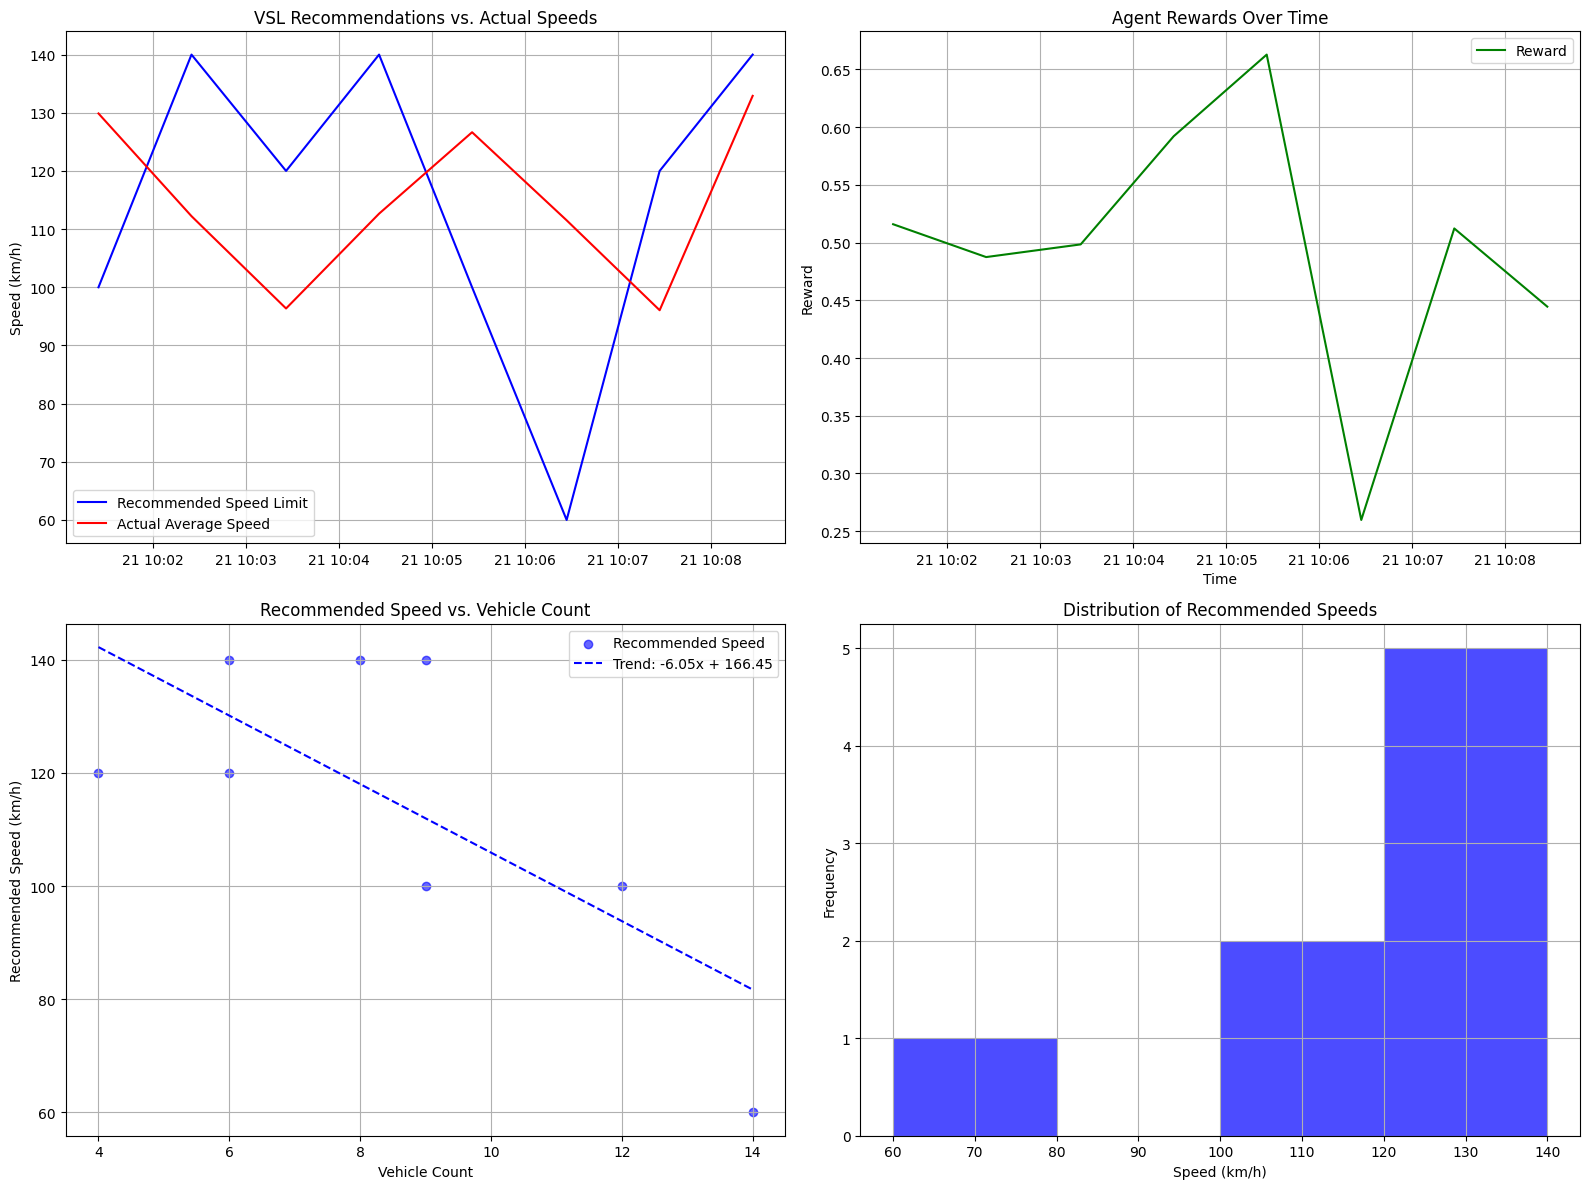

Average reward: 0.4967


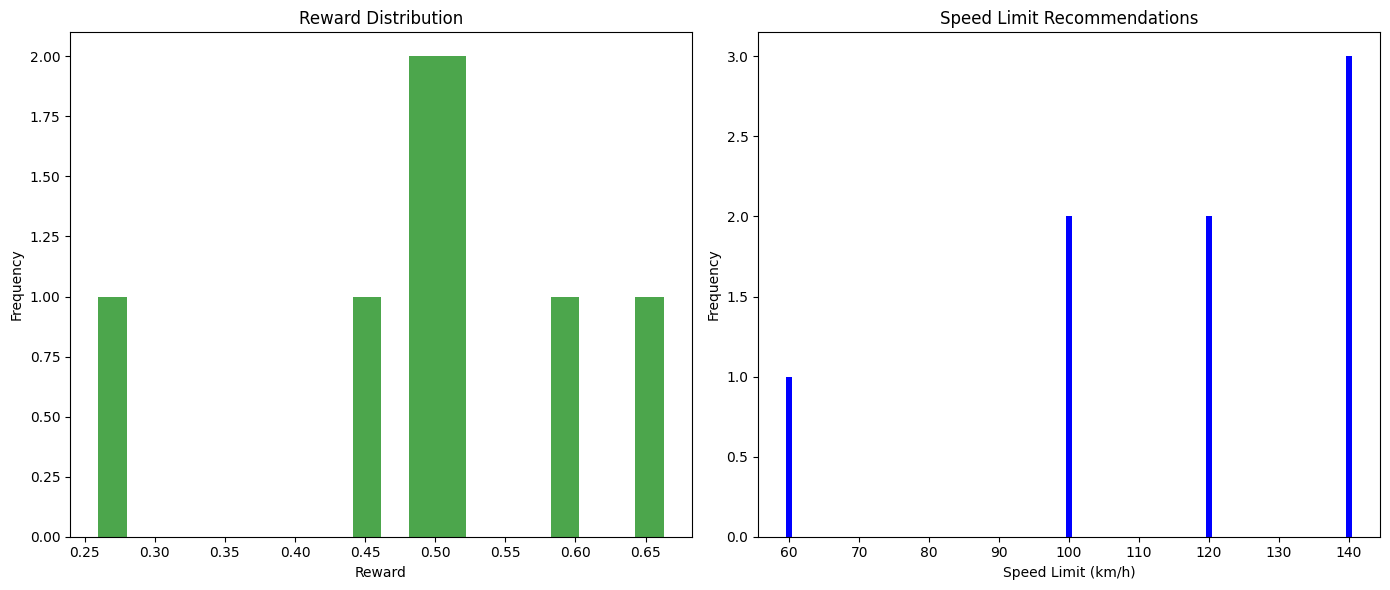

In [8]:
# Run evaluation with the best model
best_model_path = "models/vsl_best_model.weights.h5"
data_path = "traffic_data_2.csv"

results = load_and_evaluate_model(best_model_path, data_path)

if results:
    # Additional analysis
    plt.figure(figsize=(14, 6))
    
    # Plot reward distribution
    plt.subplot(1, 2, 1)
    plt.hist(results['rewards'], bins=20, alpha=0.7, color='green')
    plt.title('Reward Distribution')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    
    # Plot speed limit recommendations frequency
    plt.subplot(1, 2, 2)
    unique_speeds, counts = np.unique(results['recommended_speeds'], return_counts=True)
    plt.bar(unique_speeds, counts, color='blue')
    plt.title('Speed Limit Recommendations')
    plt.xlabel('Speed Limit (km/h)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('model_analysis.png')
    plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_16316\2972204294.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  density_analysis = merged_df.groupby('density_bin')['recommended_speed'].mean()


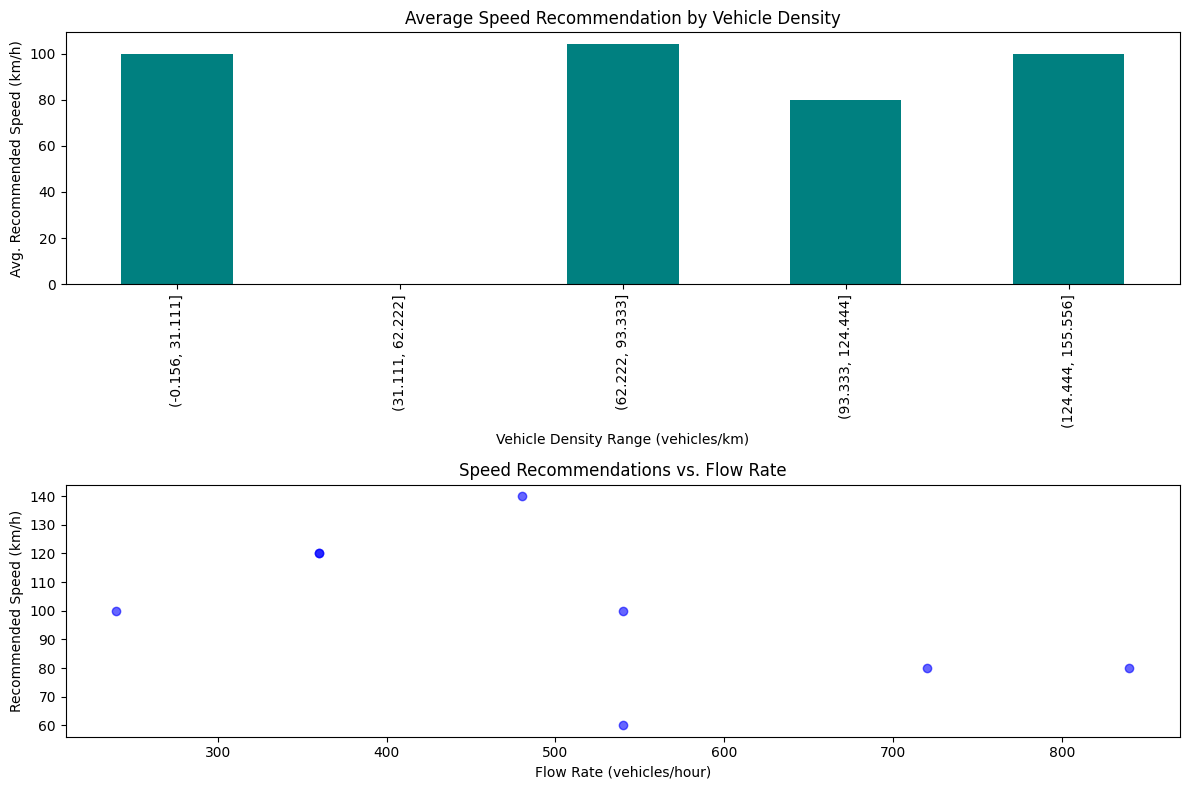

In [30]:
# Analyze the agent's behavior under different traffic conditions
def analyze_traffic_conditions(results):
    if not results:
        return
    
    # Get the data for analysis
    data = load_traffic_data("traffic_data_2.csv")
    timestamps = results['timestamps']
    recommended_speeds = results['recommended_speeds']
    actual_speeds = results['actual_speeds']
    
    # Create a dataframe for analysis
    analysis_df = pd.DataFrame({
        'timestamp': timestamps,
        'recommended_speed': recommended_speeds,
        'actual_speed': actual_speeds
    })
    
    # Merge with original data to get traffic conditions
    merged_df = pd.merge(analysis_df, data, on='timestamp')
    
    # Analyze speed recommendations based on vehicle density
    plt.figure(figsize=(12, 8))
    
    # Group by density ranges
    merged_df['density_bin'] = pd.cut(merged_df['vehicle_density_vpkm'], bins=5)
    density_analysis = merged_df.groupby('density_bin')['recommended_speed'].mean()
    
    plt.subplot(2, 1, 1)
    density_analysis.plot(kind='bar', color='teal')
    plt.title('Average Speed Recommendation by Vehicle Density')
    plt.xlabel('Vehicle Density Range (vehicles/km)')
    plt.ylabel('Avg. Recommended Speed (km/h)')
    
    # Analyze recommendations by flow rate
    plt.subplot(2, 1, 2)
    plt.scatter(merged_df['flow_rate_vph'], merged_df['recommended_speed'], alpha=0.6, c='blue')
    plt.title('Speed Recommendations vs. Flow Rate')
    plt.xlabel('Flow Rate (vehicles/hour)')
    plt.ylabel('Recommended Speed (km/h)')
    
    plt.tight_layout()
    plt.savefig('traffic_condition_analysis.png')
    plt.show()
    
    return merged_df

# Run the analysis if results are available
if 'results' in locals():
    traffic_analysis = analyze_traffic_conditions(results)

# Vehicle Count vs Recommended Speed Analysis

This section specifically focuses on analyzing how the DQN agent adjusts recommended speed limits based on the number of vehicles on the road. The visualization shows the relationship between vehicle count and the speed limits chosen by the model.

C:\Users\asus\AppData\Local\Temp\ipykernel_10104\2385388417.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_count = merged_df.groupby('vehicle_count_bin')['recommended_speed'].mean()


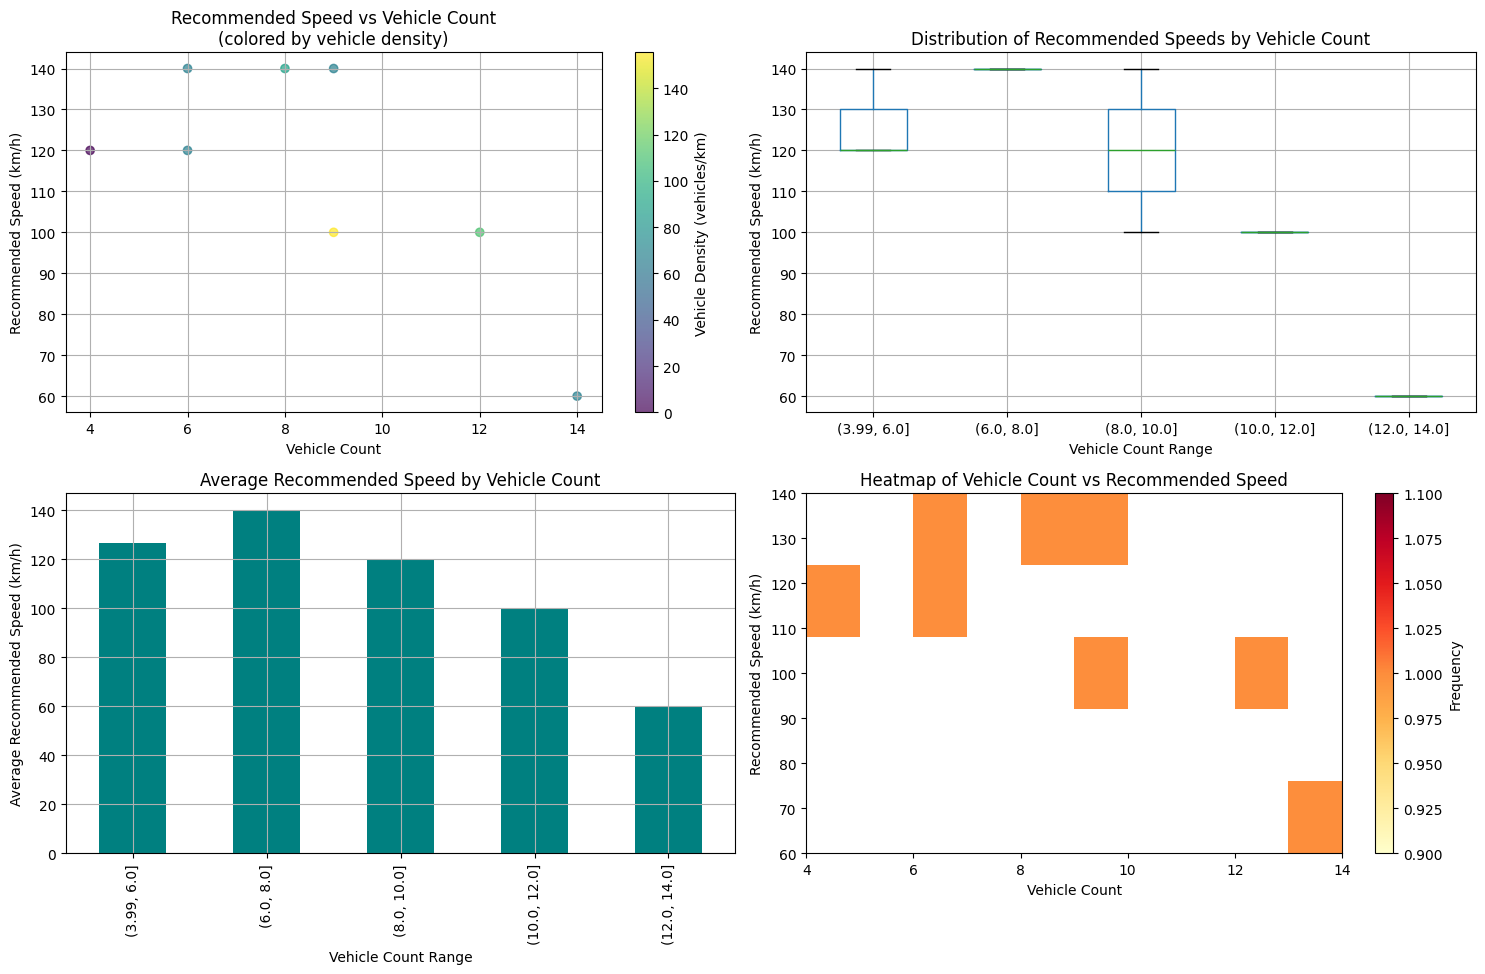

Analysis complete! The visualization shows how the model adjusts speed recommendations based on vehicle count.


In [9]:
# Specialized analysis of recommended speeds vs vehicle count
def analyze_vehicle_count_vs_speed(results):
    if not results:
        print("No results available. Please run the model evaluation first.")
        return
    
    # Load the traffic data
    data = load_traffic_data("traffic_data_2.csv")
    
    # Create a dataframe for analysis
    analysis_df = pd.DataFrame({
        'timestamp': results['timestamps'],
        'recommended_speed': results['recommended_speeds']
    })
    
    # Merge with the traffic data to get vehicle counts
    merged_df = pd.merge(analysis_df, data, on='timestamp')
    
    # Create a figure with multiple visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Scatter plot with all data points
    plt.subplot(2, 2, 1)
    plt.scatter(merged_df['vehicle_count'], merged_df['recommended_speed'], 
               c=merged_df['vehicle_density_vpkm'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Vehicle Density (vehicles/km)')
    plt.xlabel('Vehicle Count')
    plt.ylabel('Recommended Speed (km/h)')
    plt.title('Recommended Speed vs Vehicle Count\n(colored by vehicle density)')
    plt.grid(True)
    
    # 2. Boxplot of recommended speeds for different vehicle count bins
    plt.subplot(2, 2, 2)
    # Create bins for vehicle count
    merged_df['vehicle_count_bin'] = pd.cut(merged_df['vehicle_count'], bins=5)
    # Group by vehicle count bins and create boxplot
    merged_df.boxplot(column='recommended_speed', by='vehicle_count_bin', grid=True, ax=plt.gca())
    plt.xlabel('Vehicle Count Range')
    plt.ylabel('Recommended Speed (km/h)')
    plt.title('Distribution of Recommended Speeds by Vehicle Count')
    plt.suptitle('')  # Remove pandas-generated title
    
    # 3. Average recommended speed by vehicle count (binned)
    plt.subplot(2, 2, 3)
    avg_by_count = merged_df.groupby('vehicle_count_bin')['recommended_speed'].mean()
    avg_by_count.plot(kind='bar', color='teal')
    plt.xlabel('Vehicle Count Range')
    plt.ylabel('Average Recommended Speed (km/h)')
    plt.title('Average Recommended Speed by Vehicle Count')
    plt.grid(True)
    
    # 4. Heatmap of vehicle count vs recommended speed
    plt.subplot(2, 2, 4)
    # Create 2D histogram
    plt.hist2d(merged_df['vehicle_count'], merged_df['recommended_speed'], 
              bins=[10, 5], cmap='YlOrRd', cmin=1)
    plt.colorbar(label='Frequency')
    plt.xlabel('Vehicle Count')
    plt.ylabel('Recommended Speed (km/h)')
    plt.title('Heatmap of Vehicle Count vs Recommended Speed')
    
    plt.tight_layout()
    plt.savefig('vehicle_count_vs_speed_analysis.png')
    plt.show()
    
    return merged_df

# Run the specialized analysis if results are available
if 'results' in locals() and results:
    vehicle_analysis = analyze_vehicle_count_vs_speed(results)
    print("Analysis complete! The visualization shows how the model adjusts speed recommendations based on vehicle count.")
else:
    print("Please run the model evaluation first to generate results for analysis.")
